# Lending club loan Data Analysis and Predictions

In [1]:
# Loading the required Libraries
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from statistics import mode

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (roc_auc_score, confusion_matrix,
                             accuracy_score, roc_curve,
                             precision_recall_curve, f1_score,auc)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsemble

import xgboost as xgb
from scipy.stats import boxcox

import math 
from google.colab import drive 
import os 

## 5.  Model Evaluation And Validation
Machine Learning Algorithm Fitting

In this part, now that we have cleaned the dataset and encoded the variable with dummy encoding to process categorical data, let's dive in the first machine learning algorithm that we will try to use on the data set. But before, let's see the result of our work on the dataset.
1. Working on entire Data 
2. Train Test Split the Data
3. Using Models like Logistic Regression, SVM, KNN, Neural Networks for Model Validation.

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd /content/drive/My\ Drive/

/content/drive/My Drive


In [4]:
os.chdir('/content/drive/My Drive/Colab Notebooks/Lending Club')

In [5]:
path = 'data'
loan_data = pd.read_csv(path+'/loan_clean_data.csv', low_memory=False)

In [6]:
loan_data.head()

,int_rate,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,total_rec_late_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,term_ 36 months,term_ 60 months,pymnt_plan_n,initial_list_status_f,initial_list_status_w,hardship_flag_N,hardship_flag_Y,debt_settlement_flag_N,debt_settlement_flag_Y,disbursement_method_Cash,disbursement_method_DirectPay,application_type_Individual,application_type_Joint App
0,2.122115,10,5.225513,1,18.92,0.0,0.0,0.0,25416,29.9,4.410048,215.79,0.0,20228.39,0.0,0.0,0.0,1.0,2.0,0.0,1.0,13.0,71.0,1.0,2.0,9759.0,39.0,20.348704,2.0,2.0,0.0,5.0,15.579114,59684.0,29.9,0.0,0.0,171.0,12.341678,1.0,...,1.0,8.890732e+09,20.0,0.0,0.0,27.069386,16.802217,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,1,0,1,0,0,1
1,2.724158,1,5.142647,1,12.25,1.0,1.0,0.0,15927,21.8,6.165141,72.11,0.0,10082.93,0.0,0.0,0.0,1.0,2.0,0.0,1.0,23.0,39.0,1.0,2.0,8703.0,23.0,19.911623,1.0,1.0,1.0,3.0,11.696927,40231.0,23.1,0.0,0.0,159.0,10.705251,1.0,...,1.0,9.044023e+09,10.0,0.0,0.0,23.939602,14.470704,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,1,0,1,0,1,0
2,2.467951,0,5.163588,1,23.65,0.0,0.0,0.0,2252,3.1,5.825007,225.06,0.0,29300.07,0.0,0.0,0.0,3.0,3.0,0.0,1.0,16.0,39.0,4.0,5.0,1463.0,17.0,19.887920,1.0,0.0,2.0,7.0,12.864298,68267.0,3.0,0.0,0.0,114.0,9.633270,3.0,...,5.0,1.017849e+10,0.0,0.0,0.0,24.820946,14.251005,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,1,0,0,1,1,0
3,2.616890,1,5.225513,1,10.60,1.0,1.0,0.0,1229,17.3,4.626848,148.87,0.0,10158.70,0.0,0.0,0.0,1.0,3.0,1.0,2.0,12.0,48.0,1.0,2.0,963.0,44.0,18.547729,1.0,0.0,3.0,4.0,10.095657,40871.0,30.0,1.0,0.0,75.0,15.174391,0.0,...,2.0,8.930927e+08,0.0,0.0,0.0,20.763948,14.498918,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,1,0,1,0,1,0
4,2.210304,8,5.156088,1,19.87,0.0,0.0,0.0,7337,34.0,6.415187,14.29,0.0,10021.11,0.0,0.0,0.0,1.0,2.0,2.0,2.0,4.0,90.0,0.0,1.0,2965.0,67.0,16.590434,1.0,3.0,2.0,3.0,11.220394,14263.0,34.0,0.0,0.0,196.0,11.655114,13.0,...,2.0,5.415417e+09,60.0,0.0,0.0,19.218273,15.370809,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,1,0,1,0,1,0


In [7]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119819 entries, 0 to 119818
Data columns (total 95 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   int_rate                             119819 non-null  float64
 1   emp_length                           119819 non-null  int64  
 2   annual_inc                           119819 non-null  float64
 3   loan_status                          119819 non-null  int64  
 4   dti                                  119819 non-null  float64
 5   delinq_2yrs                          119819 non-null  float64
 6   inq_last_6mths                       119819 non-null  float64
 7   pub_rec                              119819 non-null  float64
 8   revol_bal                            119819 non-null  int64  
 9   revol_util                           119819 non-null  float64
 10  total_acc                            119819 non-null  float64
 11  total_rec_int

## 5.1  Evaluation Benchmark And Error Metrics

We talked about the need of a conservative evaluation of the default rate. We must also keep in mind that there is a strong imbalance with the target category of loan repayment in the dataset, because about 6 out of 7 loans are repaid. Meaning that we could lend money all the time (always predicting that the borrower would repay) and be right about 85.71% of the time that the loan would be repaid, but that would mean that the model would not be profitable. Say we lend 1000 at 10% interest, we would expect a return of 100 on each loan. But if we run the experiment 7 times, we would earn 600 (6 x 100) and lose 1000 (the defaulter), we are left with a 400 loss. Hardly a profitable enterprise. The benchmark needs to encompass the weight of the defaulter and the optimization between the true positive rate (good borrowers) and the false positive rate (bad borrowers). This implies that we need to ensure a viable machine learning model and predict a higher percentage of potential defaulters in order to avoid lending to them. The benchmark must beat the 85.71% average loan repayment. Although “money is left on the table”, a conservative investor would prefer a steady return on her investment than suffer the 1 in 7 loss.

In the markdown cell above, we talked about the class imbalance and that it could lead to an unprofitable model. If we were to lend to all borrowers, we would most likely lose 1 in 7 times and take a larger loss in that one time than in the 6 others' interest. In the code below, we check the true positive and false positive rate.

In [8]:
predictions = pd.Series(np.ones(loan_data.shape[0]))

false_positive_filter = (predictions == 1) & (loan_data['loan_status'] == 0)
false_positive = len(predictions[false_positive_filter])

true_positive_filter = (predictions == 1) & (loan_data['loan_status'] == 1)
true_positive = len(predictions[true_positive_filter])

false_negative_filter = (predictions == 0) & (loan_data['loan_status'] == 1)
false_negative = len(predictions[false_negative_filter])

true_negative_filter = (predictions == 0) & (loan_data['loan_status'] == 0)
true_negative = len(predictions[true_negative_filter])

true_positive_rate = true_positive / (true_positive + false_negative)
false_positive_rate = false_positive / (false_positive + true_negative)

print(float(true_positive_rate)) 
print(float(false_positive_rate))

1.0
1.0


In [9]:
accuracy = float(true_positive + true_negative)/float(true_positive + false_positive+ false_negative + true_negative)
accuracy

0.7727405503300812

In [10]:
precision = float(true_positive)/float(true_positive + false_positive)
precision

0.7727405503300812

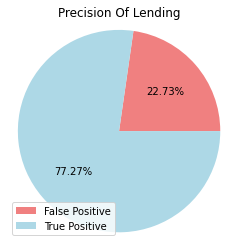

In [11]:
# Data to plot
labels = 'False Positive', 'True Positive'
sizes = [1-precision, precision]
colors = ['lightcoral', 'lightblue'] 
# Plot
plt.figure(figsize=(4,4))
plt.pie(sizes, colors=colors, autopct='%1.2f%%', shadow=False, startangle=0)
plt.title('Precision Of Lending', fontsize=12) 
plt.legend(labels, loc='lower left', fontsize=10)
plt.axis('equal')
plt.show()

## 5.2 Predictions on the Entire Data 

In [12]:
import time 
start_time =time.time()
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

cols = loan_data.columns
train_cols = cols.drop('loan_status')

features = loan_data[train_cols]

target = loan_data['loan_status']

lr.fit(features, target)
predictions = lr.predict(features)
score_lr_complete = lr.score(features,target)
print('Model Accuracy:%.4f' %(score_lr_complete))

end_time = time.time()
print('Total time taken: %s seconds'%(end_time - start_time))

Model Accuracy:0.7727
Total time taken: 1.080230474472046 seconds


In [13]:
predictions = pd.Series(predictions)

In [14]:
false_positive_filter = (predictions == 1) & (loan_data['loan_status'] == 0)
false_positive = len(predictions[false_positive_filter])

true_positive_filter = (predictions == 1) & (loan_data['loan_status'] == 1)
true_positive = len(predictions[true_positive_filter])

false_negative_filter = (predictions == 0) & (loan_data['loan_status'] == 1)
false_negative = len(predictions[false_negative_filter])

true_negative_filter = (predictions == 0) & (loan_data['loan_status'] == 0)
true_negative = len(predictions[true_negative_filter])

true_positive_rate = float(true_positive)/float((true_positive + false_negative))
false_positive_rate = float(false_positive)/float((false_positive + true_negative))

print(float(true_positive_rate))
print(float(false_positive_rate))

1.0
1.0


In [15]:
precision = float(true_positive)/float(true_positive + false_positive)
precision

0.7727405503300812

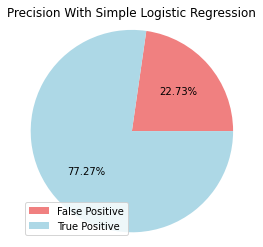

In [16]:
# Data to plot
labels = 'False Positive', 'True Positive'
sizes = [1-precision, precision]
colors = ['lightcoral', 'lightblue'] 
# Plot
plt.figure(figsize=(4,4))
plt.pie(sizes, colors=colors, autopct='%1.2f%%', shadow=False, startangle=0)
plt.title('Precision With Simple Logistic Regression', fontsize=12) 
plt.legend(labels, loc='lower left', fontsize=10)
plt.axis('equal')
plt.show()

### 5.3  Train/ Test Split Data Set

In [17]:
loan_data.shape

(119819, 95)

In [18]:
traindata, testdata = train_test_split(loan_data, stratify=loan_data['loan_status'],test_size=.3, random_state=17, shuffle=True)
testdata.reset_index(drop=True, inplace=True)
traindata.reset_index(drop=True, inplace=True)

In [19]:
sc = StandardScaler()
y_default = traindata[traindata['loan_status'] == 0]
n_paid = traindata[traindata['loan_status'] == 1].sample(n=len(y_default), random_state=17) ##chosing equal amount of 1's

data = y_default.append(n_paid) 

Xbal = data.drop('loan_status', axis=1)
ybal = data['loan_status']

Xte = testdata.drop('loan_status', axis=1)
yte = testdata['loan_status']

In [20]:
Xbal.shape

(38122, 94)

In [21]:
Xte.shape

(35946, 94)

In [22]:
numerical = Xbal.columns[(Xbal.dtypes == 'float64') | (Xbal.dtypes == 'int64')].tolist()
Xbal[numerical] = sc.fit_transform(Xbal[numerical])

numerical = Xte.columns[(Xte.dtypes == 'float64') | (Xte.dtypes == 'int64')].tolist()
Xte[numerical] = sc.fit_transform(Xte[numerical])

#### Compariosn between Random Forest And Logistic Regression Using 3 CV Score Approach

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
s1 = time.time()
models = {'RF': RandomForestClassifier(n_estimators=500), 'LR': LogisticRegression(C=1)}

balset = {}
for i in models.keys():
    scores = cross_val_score(models[i], Xbal - np.min(Xbal) + 1,
                                    ybal, scoring='roc_auc', cv=3)
    balset[i] = scores
    print(i, scores, np.mean(scores))
e1 = time.time()
print('Total time taken: %s seconds' %(e1 - s1))

RF [0.97568959 0.97659018 0.97780398] 0.9766945798263308
LR [0.96004765 0.96125735 0.96060553] 0.9606368433774736
Total time taken: 138.2263994216919 seconds


## 6. Implementing Indiviual Models 

In [24]:
rf = RandomForestClassifier(n_estimators=500, min_samples_leaf=500, class_weight='balanced',random_state=3)
lr = LogisticRegression(class_weight='balanced', random_state=3, penalty='l2', C=1)
selection_param = 0.0003

### 6.1 Logistic Regression 

Model Accuracy:0.7711
Total time taken: 1.379603624343872 seconds
TPR:  0.7041077150160204
FPR:  0.0011017260374586854
CONFUSION MATRIX:
TN:  8160    FP:  9
FN:  8219    TP:  19558


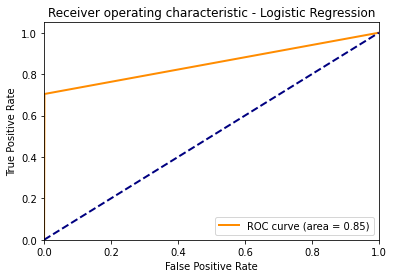

In [25]:
s2 = time.time()
lr.fit(Xbal, ybal)
predictions_lr = lr.predict(Xte)
predictions_lr = pd.Series(predictions_lr)
score_lr = lr.score(Xte,yte)
print('Model Accuracy:%.4f' %(score_lr))
e2 = time.time()
print('Total time taken: %s seconds' %(e2 -s2))

fp = len(predictions_lr[(predictions_lr == 1) & (yte.values==0)]) 
tp = len(predictions_lr[(predictions_lr == 1) & (yte.values==1)])
fn = len(predictions_lr[(predictions_lr == 0) & (yte.values==1)])  
tn = len(predictions_lr[(predictions_lr == 0) & (yte.values==0)])  
 

tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

#print(lr.coef_)
print('TPR: ',tpr)
print('FPR: ',fpr)
fprpoints, tprpoints, thresholds = roc_curve(yte, predictions_lr)
print('CONFUSION MATRIX:')
cm = confusion_matrix(yte,predictions_lr)
print('TN: ',cm[0,0], '   FP: ',cm[0,1])
print('FN: ',cm[1,0], '   TP: ',cm[1,1])

plt.figure()
lw = 2
plt.plot(fprpoints, tprpoints, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc(fprpoints,tprpoints))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

(0.0, 2.0, 2.0, 0.0)

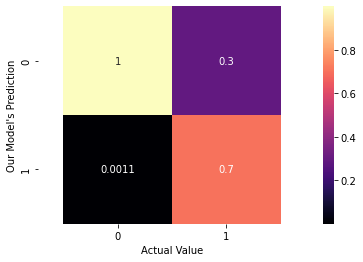

In [26]:
cm = confusion_matrix(yte, predictions_lr).T
cm = cm.astype('float')/cm.sum(axis=0)
ax = sns.heatmap(cm, annot=True, cmap='magma');
ax.set_xlabel('Actual Value')
ax.set_ylabel("Our Model's Prediction")
ax.axis('equal')

## 6.2 Random Forest

Model Accuracy:0.7981
Total time taken: 31.60842800140381 seconds
TPR:  0.7438528278791806
FPR:  0.017382788591014813
CONFUSION MATRIX:
TN:  8027    FP:  142
FN:  7115    TP:  20662


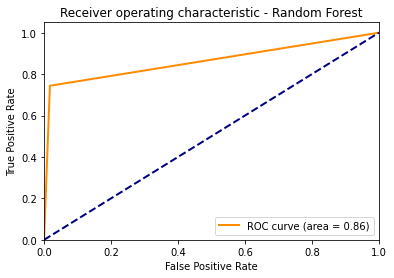

In [27]:
s3 = time.time()

rf.fit(Xbal, ybal)
predictions_rf = rf.predict(Xte)
predictions_rf = pd.Series(predictions_rf)
score_rf = rf.score(Xte,yte)
print('Model Accuracy:%.4f' %(score_rf))

e3 = time.time()
print('Total time taken: %s seconds' %(e3 -s3))

fp = len(predictions_rf[(predictions_rf == 1) & (yte.values==0)]) 
tp = len(predictions_rf[(predictions_rf == 1) & (yte.values==1)])
fn = len(predictions_rf[(predictions_rf == 0) & (yte.values==1)])  
tn = len(predictions_rf[(predictions_rf == 0) & (yte.values==0)])  
 

tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

#print(lr.coef_)
print('TPR: ',tpr)
print('FPR: ',fpr)
fprpoints, tprpoints, thresholds = roc_curve(yte, predictions_rf)
print('CONFUSION MATRIX:')
cm1 = confusion_matrix(yte,predictions_rf)
print('TN: ',cm1[0,0], '   FP: ',cm1[0,1])
print('FN: ',cm1[1,0], '   TP: ',cm1[1,1])
plt.figure()
lw = 2
plt.plot(fprpoints, tprpoints, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc(fprpoints,tprpoints))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Random Forest')
plt.legend(loc="lower right")
plt.show()

(0.0, 2.0, 2.0, 0.0)

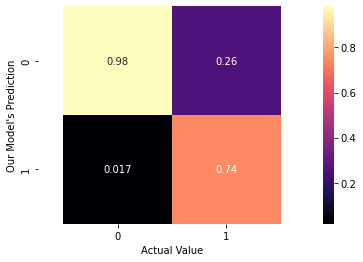

In [28]:
cm1 = confusion_matrix(yte, predictions_rf).T
cm1 = cm1.astype('float')/cm1.sum(axis=0)
ax = sns.heatmap(cm1, annot=True, cmap='magma');
ax.set_xlabel('Actual Value')
ax.set_ylabel("Our Model's Prediction")
ax.axis('equal')

## 6.3. K Nearest Neighbors (KNN)

Model Accuracy:0.6872
Total time taken: 490.42539620399475 seconds
TPR:  0.6749468985131584
FPR:  0.27102460521483657
CONFUSION MATRIX:
TN:  5955    FP:  2214
FN:  9029    TP:  18748


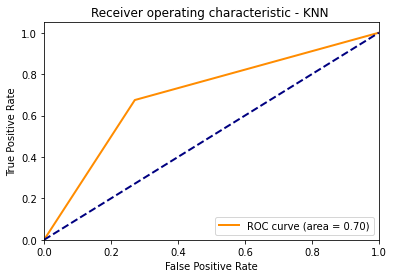

In [29]:
s4 = time.time()

data_knn = KNeighborsClassifier(n_neighbors = 5, metric='minkowski',n_jobs =-1, algorithm = 'auto')
data_knn.fit(Xbal, ybal)

predictions_knn = data_knn.predict(Xte)
predictions_knn = pd.Series(predictions_knn)

score_knn = data_knn.score(Xte,yte)
print('Model Accuracy:%.4f' %(score_knn))

e4 = time.time()
print('Total time taken: %s seconds' %(e4 -s4))


fp = len(predictions_knn[(predictions_knn == 1) & (yte.values==0)]) 
tp = len(predictions_knn[(predictions_knn == 1) & (yte.values==1)])
fn = len(predictions_knn[(predictions_knn == 0) & (yte.values==1)])  
tn = len(predictions_knn[(predictions_knn == 0) & (yte.values==0)])  
 

tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

#print(lr.coef_)
print('TPR: ',tpr)
print('FPR: ',fpr)
fprpoints, tprpoints, thresholds = roc_curve(yte, predictions_knn)
print('CONFUSION MATRIX:')
cm3 = confusion_matrix(yte,predictions_knn)
print('TN: ',cm3[0,0], '   FP: ',cm3[0,1])
print('FN: ',cm3[1,0], '   TP: ',cm3[1,1])
plt.figure()
lw = 2
plt.plot(fprpoints, tprpoints, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc(fprpoints,tprpoints))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - KNN ')
plt.legend(loc="lower right")
plt.show()

(0.0, 2.0, 2.0, 0.0)

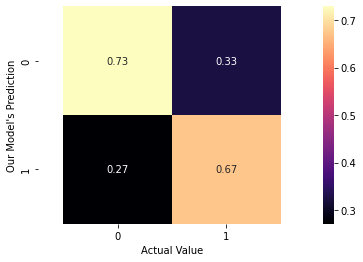

In [30]:
cm3 = confusion_matrix(yte, predictions_knn).T
cm3 = cm3.astype('float')/cm3.sum(axis=0)
ax = sns.heatmap(cm3, annot=True, cmap='magma');
ax.set_xlabel('Actual Value')
ax.set_ylabel("Our Model's Prediction")
ax.axis('equal')

## 6.4  SVM 

Model Accuracy:0.7498
Total time taken: 411.9357810020447 seconds
TPR:  0.677934982179501
FPR:  0.0058758721997796545
CONFUSION MATRIX:
TN:  8121    FP:  48
FN:  8946    TP:  18831


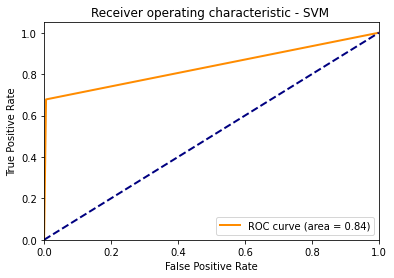

In [31]:
s5 = time.time()

Svm = sklearn.svm.SVC()
Svm.fit(Xbal, ybal)
predictions_svm = Svm.predict(Xte)
predictions_svm = pd.Series(predictions_svm)
score_Svm = Svm.score(Xte,yte)
print('Model Accuracy:%.4f' %(score_Svm))


e5 = time.time()
print('Total time taken: %s seconds' %(e5 -s5))


fp = len(predictions_svm[(predictions_svm == 1) & (yte.values==0)]) 
tp = len(predictions_svm[(predictions_svm == 1) & (yte.values==1)])
fn = len(predictions_svm[(predictions_svm == 0) & (yte.values==1)])  
tn = len(predictions_svm[(predictions_svm == 0) & (yte.values==0)])  
 

tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

#print(lr.coef_)
print('TPR: ',tpr)
print('FPR: ',fpr)
fprpoints, tprpoints, thresholds = roc_curve(yte, predictions_svm)
print('CONFUSION MATRIX:')
cm2 = confusion_matrix(yte,predictions_svm)
print('TN: ',cm2[0,0], '   FP: ',cm2[0,1])
print('FN: ',cm2[1,0], '   TP: ',cm2[1,1])
plt.figure()
lw = 2
plt.plot(fprpoints, tprpoints, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc(fprpoints,tprpoints))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - SVM ')
plt.legend(loc="lower right")
plt.show()

(0.0, 2.0, 2.0, 0.0)

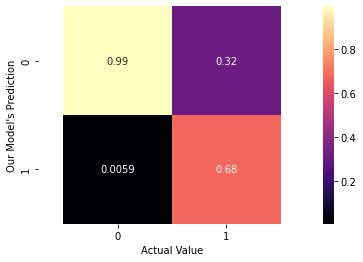

In [32]:
cm2 = confusion_matrix(yte, predictions_svm).T
cm2 = cm2.astype('float')/cm2.sum(axis=0)
ax = sns.heatmap(cm2, annot=True, cmap='magma');
ax.set_xlabel('Actual Value')
ax.set_ylabel("Our Model's Prediction")
ax.axis('equal')

## 6.5 XGB  Classifier 

In [33]:
from xgboost import XGBClassifier

Model Accuracy: 0.7558
Total time taken: 9.534958839416504 seconds
TPR:  0.930806062569752
FPR:  0.8393928265393561
CONFUSION MATRIX:
TN:  1312    FP:  6857
FN:  1922    TP:  25855


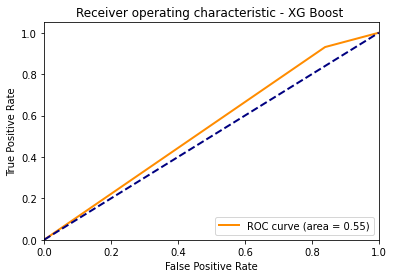

In [34]:
s7 = time.time()
model = XGBClassifier()
model.fit(Xbal, ybal)

predictions_xgb = model.predict(Xte)
prediction_xgb = [round(value) for value in predictions_xgb]
prediction_xgb = np.array(prediction_xgb)

accuracy = accuracy_score(yte, prediction_xgb)
print("Model Accuracy: %.4f" % (accuracy))

e7 = time.time()
print('Total time taken: %s seconds' %(e7 -s7))

fp = len(prediction_xgb[(prediction_xgb == 1) & (yte.values==0)]) 
tp = len(prediction_xgb[(prediction_xgb == 1) & (yte.values==1)])
fn = len(prediction_xgb[(prediction_xgb == 0) & (yte.values==1)])  
tn = len(prediction_xgb[(prediction_xgb == 0) & (yte.values==0)])  
 

tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

#print(lr.coef_)
print('TPR: ',tpr)
print('FPR: ',fpr)
fprpoints, tprpoints, thresholds = roc_curve(yte, prediction_xgb)
print('CONFUSION MATRIX:')
cm4 = confusion_matrix(yte,predictions_xgb)
print('TN: ',cm4[0,0], '   FP: ',cm4[0,1])
print('FN: ',cm4[1,0], '   TP: ',cm4[1,1])
plt.figure()
lw = 2
plt.plot(fprpoints, tprpoints, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc(fprpoints,tprpoints))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - XG Boost ')
plt.legend(loc="lower right")
plt.show()


(0.0, 2.0, 2.0, 0.0)

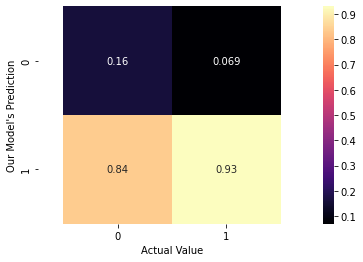

In [35]:
cm4 = confusion_matrix(yte, prediction_xgb).T
cm4 = cm4.astype('float')/cm4.sum(axis=0)
ax = sns.heatmap(cm4, annot=True, cmap='magma');
ax.set_xlabel('Actual Value')
ax.set_ylabel("Our Model's Prediction")
ax.axis('equal')

# 6.6 Neural Network

### 6.6.1 Converting the matrix Features into tensorflow variable Shape. Also defing the parameters requried for the model. 

In [57]:
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


In [37]:
Xbal.shape

(38122, 94)

In [38]:
ybal.shape

(38122,)

In [39]:
Ybal= ybal

In [40]:
Ybal =Ybal.values.flatten()

In [41]:
Ybal =np.reshape(Ybal,(38122,1))

In [42]:
Ybal.shape

(38122, 1)

In [43]:
Xte.shape

(35946, 94)

In [44]:
yte.shape

(35946,)

In [45]:
Yte =yte.values.flatten()

In [46]:
Yte =np.reshape(Yte,(35946,1))

In [47]:
Yte.shape

(35946, 1)

In [48]:
learning_rate = 0.001
training_epochs = 1000
batch_size = 128

In [49]:
n_classes = Ybal.shape[1]
n_samples = 74068
n_inputs = Xte.shape[1]

In [50]:
n_classes

1

In [51]:
n_samples

74068

In [52]:
n_inputs

94

In [53]:
n_hidden_1 = 15
n_hidden_2 = 15

### 6.6.2 Creating the Model 

In [54]:
def multilayer_network(X,weights,biases,keep_prob):
    '''
    X: Placeholder for data inputs
    weights: dictionary of weights
    biases: dictionary of bias values
    
    '''
    #first hidden layer with sigmoid activation
    # sigmoid(X*W+b)
    
    with tf.name_scope('layer1'):
        layer_1 = tf.add(tf.matmul(X,weights['h1']),biases['h1'])
        layer_1 = tf.nn.sigmoid(layer_1)
        layer_1 = tf.nn.dropout(layer_1,keep_prob)
    
    #second hidden layer
    with tf.name_scope('layer2'):
        layer_2 = tf.add(tf.matmul(layer_1,weights['h2']),biases['h2'])
        layer_2 = tf.nn.sigmoid(layer_2)
        layer_2 = tf.nn.dropout(layer_2,keep_prob)
    
    #output layer
    with tf.name_scope('output_layer'):
        out_layer = tf.matmul(layer_2,weights['out']) + biases['out']
        tf.summary.histogram("output_for_the_layer",out_layer)
    
    return out_layer

In [58]:
# defining the weights and biases dictionary

with tf.name_scope("weights"):
    weights = {
        'h1': tf.Variable(tf.random_normal([n_inputs,n_hidden_1]),name='W_input'),
        'h2': tf.Variable(tf.random_normal([n_hidden_1,n_hidden_2]),name='W_layer1'),
        'out': tf.Variable(tf.random_normal([n_hidden_2,n_classes]),name='W_layer2')
    }
    tf.summary.histogram("weights1",weights['h1'])
    tf.summary.histogram("weights2",weights['h2'])
    tf.summary.histogram("weights_out",weights['out'])
with tf.name_scope("biases"):
    biases = {
        'h1': tf.Variable(tf.random_normal([n_hidden_1]),name='b_input'),
        'h2': tf.Variable(tf.random_normal([n_hidden_2]),name='b_layer1'),
        'out': tf.Variable(tf.random_normal([n_classes]),name='b_layer2')
    }
    tf.summary.histogram("bias_input",biases['h1'])
    tf.summary.histogram("bias_layer1",biases['h2'])
    tf.summary.histogram("bias_layer2",biases['out'])
keep_prob = tf.placeholder("float")

In [59]:
with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32,[None,n_inputs],name='x_inputs')
    Y = tf.placeholder(tf.float32,[None,n_classes],name='y_inputs')

In [60]:
#obtaining predictions of the model
predictions = multilayer_network(X,weights,biases,keep_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [61]:
#cost function(loss) and optimizer function
with tf.name_scope('loss'):
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=predictions,labels=Y))
    tf.summary.scalar('loss',cost)

with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
predicted = tf.nn.sigmoid(predictions)
correct_prediction = tf.equal(tf.round(predicted), Y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar("Accuracy",accuracy)

<tf.Tensor 'Accuracy:0' shape=() dtype=string>

### 6.6.3 Evaluating the Model 

In [62]:
#initializing all variables
init = tf.global_variables_initializer()

In [63]:
with tf.Session() as sess:
    sess.run(init)
    s6 = time.time()
    acc_list=  []
    loss_list = []
    pred = []
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter("logs/",sess.graph)

    #for loop

    for epoch in range(training_epochs):
        avg_cost = 0.0
        total_batch = int(len(Xbal)/ batch_size)
        x_batches = np.array_split(Xbal, total_batch)
        y_batches = np.array_split(Ybal, total_batch)
        for i in range(total_batch):
            batch_x, batch_y = x_batches[i], y_batches[i]
            _,c,p = sess.run([optimizer,cost,predictions], 
                            feed_dict={
                                X: batch_x, 
                                Y: batch_y, 
                                keep_prob: 0.8
                            })
            avg_cost += c / total_batch
            
        print("Epoch:", '%04d' % (epoch+1), "Loss=", 
                "{:.9f}".format(avg_cost))
        
        acc,res,predicts = sess.run([accuracy,merged,predictions], feed_dict={X: Xte, Y: Yte,keep_prob:1.0})
        writer.add_summary(res,epoch)
        print('Accuracy:', acc)
        acc_list.append(acc)
        loss_list.append(avg_cost)
        pred.append(predicts)
        print ('---------------')
    e6 = time.time()   
    print("Model has completed {} epochs of training".format(training_epochs))
    print('Total Time Taken: %s' %(e6 - s6))

Epoch: 0001 Loss= 0.912925831
Accuracy: 0.73654926
---------------
Epoch: 0002 Loss= 0.874621128
Accuracy: 0.76943195
---------------
Epoch: 0003 Loss= 0.848194211
Accuracy: 0.7867635
---------------
Epoch: 0004 Loss= 0.801817735
Accuracy: 0.7980304
---------------
Epoch: 0005 Loss= 0.755378474
Accuracy: 0.80768377
---------------
Epoch: 0006 Loss= 0.717488711
Accuracy: 0.81533414
---------------
Epoch: 0007 Loss= 0.682190257
Accuracy: 0.8217048
---------------
Epoch: 0008 Loss= 0.648587555
Accuracy: 0.82782507
---------------
Epoch: 0009 Loss= 0.617160872
Accuracy: 0.8338619
---------------
Epoch: 0010 Loss= 0.578967276
Accuracy: 0.8412897
---------------
Epoch: 0011 Loss= 0.548006670
Accuracy: 0.8454626
---------------
Epoch: 0012 Loss= 0.516618253
Accuracy: 0.8496634
---------------
Epoch: 0013 Loss= 0.489548435
Accuracy: 0.8538363
---------------
Epoch: 0014 Loss= 0.465203773
Accuracy: 0.85647917
---------------
Epoch: 0015 Loss= 0.442583144
Accuracy: 0.856507
---------------
Epoch

### 6.6.4 Plotting both the Loss and Accuracy Function

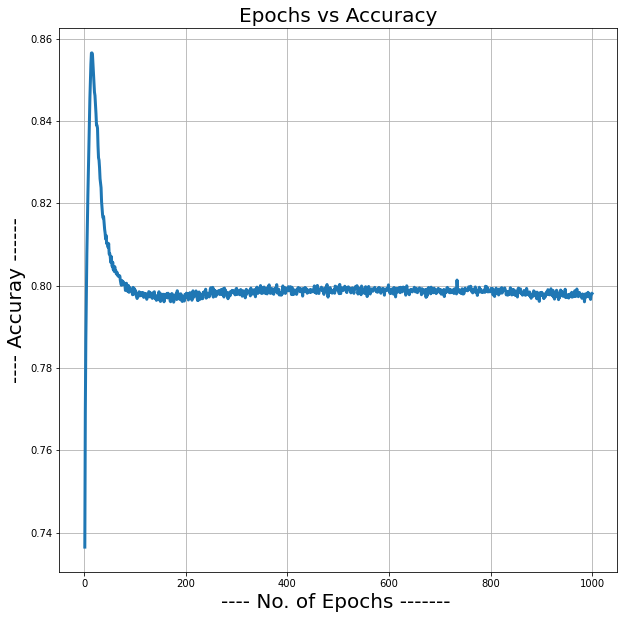

In [64]:
x = np.arange(1,1001)
y = acc_list
plt.figure(figsize =(10,10))
plt.plot(x,y, linewidth = 3.0)
plt.grid()
plt.xlabel('---- No. of Epochs ------- ', fontsize=20)
plt.ylabel('---- Accuray ------',fontsize = 20)
plt.title('Epochs vs Accuracy', fontsize =20)
plt.show()

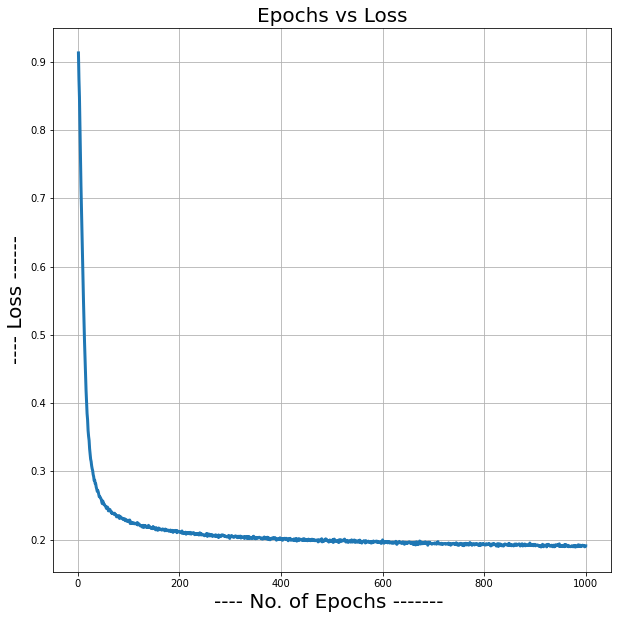

In [65]:
x = np.arange(1,1001)
y = loss_list
plt.figure(figsize =(10,10))
plt.grid()
plt.plot(x,y, linewidth = 3.0)
plt.xlabel('---- No. of Epochs ------- ', fontsize=20)
plt.ylabel('---- Loss ------',fontsize = 20)
plt.title('Epochs vs Loss', fontsize =20)
plt.show()

### Comparision of the ROC Curves for DIfferent Models  and Results Interpretation

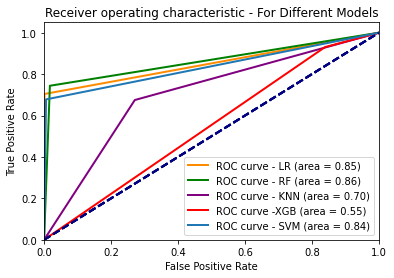

In [66]:
fprpoints, tprpoints, thresholds = roc_curve(yte, predictions_lr)

lw = 2
plt.plot(fprpoints, tprpoints, color='darkorange', lw=lw, label='ROC curve - LR (area = %0.2f)' % auc(fprpoints,tprpoints))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')



fp = len(predictions_rf[(predictions_rf == 1) & (yte.values==0)]) 
tp = len(predictions_rf[(predictions_rf == 1) & (yte.values==1)])
fn = len(predictions_rf[(predictions_rf == 0) & (yte.values==1)])  
tn = len(predictions_rf[(predictions_rf == 0) & (yte.values==0)])  
 

fprpoints, tprpoints, thresholds = roc_curve(yte, predictions_rf)
lw = 2
plt.plot(fprpoints, tprpoints, color='green', lw=lw, label='ROC curve - RF (area = %0.2f)' % auc(fprpoints,tprpoints))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


fprpoints, tprpoints, thresholds = roc_curve(yte, predictions_knn)
lw = 2
plt.plot(fprpoints, tprpoints, color='purple', lw=lw, label='ROC curve - KNN (area = %0.2f)' % auc(fprpoints,tprpoints))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")



fprpoints, tprpoints, thresholds = roc_curve(yte, prediction_xgb)
lw = 2
plt.plot(fprpoints, tprpoints, color ='red',lw=lw, label='ROC curve -XGB (area = %0.2f)' % auc(fprpoints,tprpoints))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - For Different Models')

fprpoints, tprpoints, thresholds = roc_curve(yte, predictions_svm)
lw = 2
plt.plot(fprpoints, tprpoints, lw=lw, label='ROC curve - SVM (area = %0.2f)' % auc(fprpoints,tprpoints))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc="lower right")




plt.show()

From the Above ROC plot we can see that Random Forest has outperformed all the other models. Logisitic Regression has also done quite Well, when compared with SVM We see that SVM has taken more time to compute the Classification of Loans either Charged or Paid off. 
XGB has performed the worst among all the models and it would be not recommed to use for this Data Set. 

A Neural Network Model was trained for 1000 epochs, the accuracy which it got was 0.7980, it outperformed all the models. The computation time for Neural Network was the most expensive compared to all the other models. 